In [1]:
import itertools

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from paths import *
from constants import EPISODE_LEN, RANDOM_SEED, N_CLUSTERS

%matplotlib inline

### Sepsis

#### Load data

In [2]:
# Sepsis data
sepsis = pd.read_csv(DATA/'raw/Sepsis/Sepsis_imp.csv')
print(sepsis.shape)
sepsis.head()

(252204, 59)


,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,SOFA,SIRS,Weight_kg,...,input_total_tev,input_4hourly_tev,output_total,output_4hourly,cumulated_balance_tev,sedation,mechvent,rrt,died_in_hosp,mortality_90d
0,1,3,7245052800,0,17639.826435,0.0,0,9,4,77.5,...,3500.0,2100.0,230.0,230.0,3270.0,0,0,0,0,1
1,2,3,7245067200,0,17639.826435,0.0,0,8,3,77.5,...,5499.0,1999.0,697.0,467.0,4802.0,0,0,0,0,1
2,3,3,7245081600,0,17639.826435,0.0,0,7,3,77.5,...,5604.0,105.0,2302.0,1605.0,3302.0,0,0,0,0,1
3,4,3,7245096000,0,17639.826435,0.0,0,6,3,77.5,...,5664.0,60.0,2922.0,620.0,2742.0,0,0,0,0,1
4,5,3,7245110400,0,17639.826435,0.0,0,5,3,77.5,...,5724.0,60.0,3352.0,430.0,2372.0,0,0,0,0,1


#### Preprocessing

##### Filter based on EPISODE LEN

In [3]:
sepsis.set_index('icustayid', inplace=True)

# Remove patients with episode length < EPISODE_LEN
episode_len = sepsis\
    .groupby(sepsis.index)\
    .agg({'bloc': lambda s: s.max()})

sepsis = sepsis.loc[
    episode_len[episode_len >= EPISODE_LEN].dropna().index.tolist()
]

# Clip episodes to EPISODE_LEN
sepsis = sepsis.loc[sepsis ['bloc'] <= EPISODE_LEN]

# Keep only those patients which have data for all timesteps till EPISODE_LEN
all_ts_patients = sepsis.groupby(sepsis.index).agg({'bloc': lambda lst: len(set(lst))}) == EPISODE_LEN
sepsis = sepsis.loc[all_ts_patients[all_ts_patients.bloc].index.tolist()]

#####  Discretize actions

In [4]:
# Get quartiles of action variables
vaso_quartiles = list(
    sepsis.loc[sepsis['max_dose_vaso'] > 0, 'max_dose_vaso'].quantile([0.25,0.50,0.75])
)

iv_quartiles = list(
    sepsis.loc[sepsis['input_4hourly_tev'] > 0, 'input_4hourly_tev'].quantile([0.25,0.50,0.75])
)
vaso_quartiles = [0] + vaso_quartiles
iv_quartiles = [0] + iv_quartiles

# Discretize action variables by mapping to the quartile they lie in
sepsis['iv_level'] = 0
sepsis['vaso_level'] = 0

for qrt in vaso_quartiles:
    sepsis['iv_level'] += (sepsis['max_dose_vaso'] <= qrt).values
    
for qrt in iv_quartiles:
    sepsis['vaso_level'] += (sepsis['input_4hourly_tev'] <= qrt).values
    
# Combine and map to a single identifier
action_to_id = {(j,k): i for i, (j,k) in enumerate(itertools.product(list(range(5)), list(range(5))))}
sepsis['action'] = sepsis.apply(lambda row: action_to_id[row['iv_level'], row['vaso_level']], axis=1)

4    95153
1     6261
2     6001
3     5917
0     5478
Name: iv_level, dtype: int64

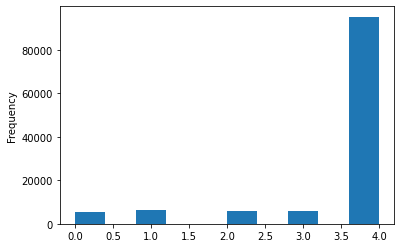

In [5]:
sepsis['iv_level'].astype(int).plot.hist()
sepsis['iv_level'].value_counts()

4    24076
1    23885
2    23720
3    23711
0    23418
Name: vaso_level, dtype: int64

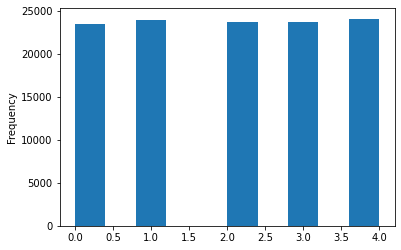

In [6]:
sepsis['vaso_level'].plot.hist()
sepsis['vaso_level'].value_counts()

#### Train-test split

In [7]:
train_ids, test_ids = train_test_split(sepsis.index.unique().tolist(), test_size=0.2, random_state=RANDOM_SEED)
sepsis_train = sepsis.loc[train_ids].reset_index()
sepsis_test = sepsis.loc[test_ids].reset_index()

#### Discretize state space

In [8]:
# Feature names
cluster_fnames = (DATA/'raw/Sepsis/features.txt').open('r').read().split('\n')[:-1]
cluster_fnames.remove('SOFA')
cluster_fnames.remove('bloc')
print("Total number of features used for clustering: ", len(cluster_fnames))

Total number of features used for clustering:  46


In [9]:
# Clustering
# Standardize
ss = StandardScaler()
ss.fit(sepsis_train[cluster_fnames])

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_SEED, verbose=0, n_init=5, n_jobs=-1)
kmeans.fit(ss.transform(sepsis_train[cluster_fnames]))

C:\ProgramData\Anaconda3\envs\espsrl\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


KMeans(n_clusters=100, n_init=5, n_jobs=-1, random_state=116687)

In [10]:
sepsis_train['state'] = kmeans.labels_
sepsis_test['state']  = kmeans.predict(ss.transform(sepsis_test[cluster_fnames]))

#### Write to disk

In [11]:
sepsis_train.rename({'SOFA': 'reward'}, axis=1, inplace=True)
sepsis_test.rename({'SOFA': 'reward'}, axis=1, inplace=True)

In [12]:
rel_fnames = ['bloc', 'icustayid', 'state', 'reward', 'action', 'died_in_hosp']
sepsis_train[rel_fnames].to_csv(DATA/'processed/sepsis/train.tsv', sep='\t', index=None)
sepsis_test[rel_fnames].to_csv(DATA/'processed/sepsis/test.tsv', sep='\t', index=None)

In [13]:
sepsis_train[['state'] + cluster_fnames].to_csv(DATA/'processed/sepsis/clustering_features.tsv', sep='\t', index=None)